In [60]:
# Import libraries:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import KFold
from collections import defaultdict
import pprint

In [82]:
# Assignment Constants
RANDOM_STATE = 10
FIGSIZE = (12,8)
#### Use the following line before plt.plot(....) to increase the plot size ####
# plt.figure(figsize=FIGSIZE)

## Question 1 
Use the breast cancer data set from Homework 0 to create a training set. Recall that the
label is 0 if the patient’s data indicates a malignant cancer and 1 otherwise. Compute the
base rate of malignant cancer occurrence over the entire data set. In other words, what would
be your best guess for the probability of malignant cancer of a single example using only the
labels in the training set? This question is very simple, so try not to overthink it.

In [83]:
cancer = load_breast_cancer()

In [84]:
print(cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [85]:
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)

In [86]:
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [87]:
# Extract the labels
target = pd.Series(cancer.target, name='target')

# You can also add the labels to the DataFrame if you want
df['target'] = target

# Count the number of rows for each label
target_counts = df['target'].value_counts()

print(target_counts)

target
1    357
0    212
Name: count, dtype: int64


In [88]:
malignant_base_prob = target_counts[0] / target_counts.sum()

print(malignant_base_prob)

0.37258347978910367


## 2
The goal is to build a decision tree that, based on the other features in the set, predicts
whether or not a patient has malignant cancer. So this is a classification problem. Using
`tree.DecisionTreeClassifier` and other functions in the scikit-learn library, one can build
a decision tree and calculate both its training accuracy when fitted to the entire data set as
well as its accuracy using 10-fold cross validation (which gives a better idea of true accuracy).
In this question you will need to complete two sub-components:
### (a) 
(a) Make a plot visualizing the performance of a `tree.DecisionTreeClassifier` as you
search for an optimal `max_depth` parameter. Vary the depth of your decision tree using
max depth = 1,2,. . . ,10 and record the results from the following evaluation procedures
for each setting:
* The accuracy when training and testing on the full dataset.
* 10-fold cross-validated accuracy.

Plot the results of both evaluation procedures on the same plot with evaluation scores on
the y-axis and max depth values on the x-axis. Use 10 as your random seed/state for the
decision tree and the cross-validation. Use a legend to label both evaluation procedures.


In [89]:
# Pull values of interest into variables
X = df.drop('target', axis=1)
y = df['target']

In [90]:
# Create two lists to track accuracy and cross-validation accuracy
train_acc_list = []
cv_acc_list = []

In [91]:
# Define the KFold cv as per the requirements
cv = KFold(n_splits=10, random_state=10, shuffle=True)

# Create loop to train classifier and track accuracies each iteration
for depth in range(1,11):
    # Initialize the DecisionTreeClassifier
    clf = DecisionTreeClassifier(max_depth=depth, random_state=RANDOM_STATE)
    
    # Train and evaluate on the full dataset
    clf.fit(X, y)
    train_accuracy = clf.score(X, y)
    train_acc_list.append(train_accuracy)

    # Perform 10-fold cross-validation
    cv_accuracy = np.mean(cross_val_score(clf, X, y, cv=cv))
    cv_acc_list.append(cv_accuracy)

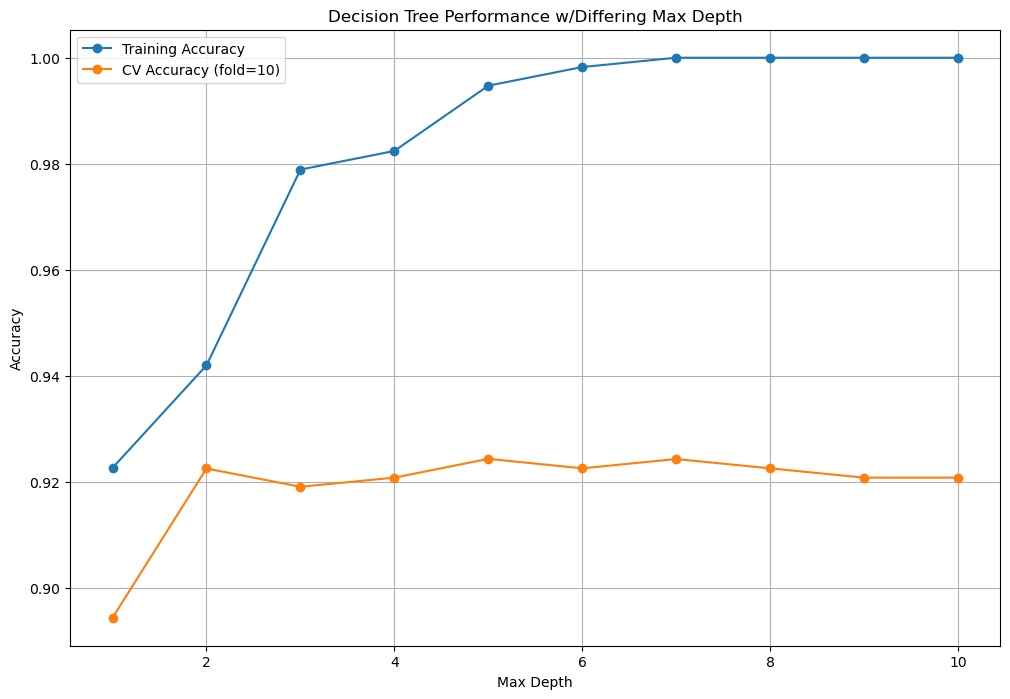

In [92]:
# Plot the figure
plt.figure(figsize=FIGSIZE)
plt.plot(range(1, 11), train_acc_list, marker='o', label='Training Accuracy')
plt.plot(range(1, 11), cv_acc_list, marker='o', label='CV Accuracy (fold=10)')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Performance w/Differing Max Depth')
plt.legend()
plt.grid(True)
plt.show()

In [93]:
# Find the maximum training accuracy
max_train_acc = max(train_acc_list)

# Find all max_depth settings that resulted in the maximum cross-validated accuracy using enumerate
best_train_depth = [depth + 1 for depth, accuracy in enumerate(train_acc_list) if accuracy == max_train_acc]

best_train_depth, max_train_acc

([7, 8, 9, 10], 1.0)

In [94]:
# Find the maximum cross-validated accuracy
max_cv_acc = max(cv_acc_list)

# Find all max_depth settings that resulted in the maximum cross-validated accuracy using enumerate
best_cv_depth = [depth + 1 for depth, accuracy in enumerate(cv_acc_list) if accuracy == max_cv_acc]

best_cv_depth, max_cv_acc

([5], 0.9243734335839597)

### (b) 
Answer the questions below based on the results of 2a. Write your answers in the
corresponding field in the markdown cell that is present in the HW1 template notebook.
Do this by double clicking the markdown cell and writing your answer directly in the
cell. Pressing enter will re-render the markdown.

#### (i.)
What setting of `max_depth` gave the best accuracy w.r.t. the **full-dataset** accuracy?
If more than one setting equaled the best accuracy, list each of the best settings.

**Student answer here:** max depths of 7, 8, 9, 10 as they all had a result of 1.0

#### (ii.)
What setting of `max_depth`  gave the best accuracy w.r.t. the **cross-
validated** accuracy? If more than one setting equaled the best accuracy, list each of the best settings.

**Student answer here:** max depths of 5 with result of 0.924



## 3\. 
This question explores random forest classifiers by using scikit-learn’s `ensemble.RandomForestClassifier`.
You will make two plots and answer questions about them.

### (a) 
For the first plot, use a `ensemble.RandomForestClassifier` and the best depth you
found 2(b)ii as `max_depth`. We will now find the optimal setting of a second parameter,
n estimators. Vary the number of trees in the forest via the parameter `n_estimators`
and plot its 10-fold cross-validated accuracy (use `n_estimators` = 1, 2, . . . , 20). Again,
use 10 as your random seed for your classifier and cross-validation.

In [95]:
# Initialize list to store cross-validated accuracy results
cv_acc_rf_list = []

# Vary the n_estimators parameter from 1 to 20
for n_estimators in range(1, 21):
    # Initialize the RandomForestClassifier with the specified random seed and max_depth of 5 from previous answer
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=5, random_state=RANDOM_STATE)
    
    # Calculate and track CV
    cv_acc_rf = np.mean(cross_val_score(clf, X, y, cv=cv))
    cv_acc_rf_list.append(cv_acc_rf)

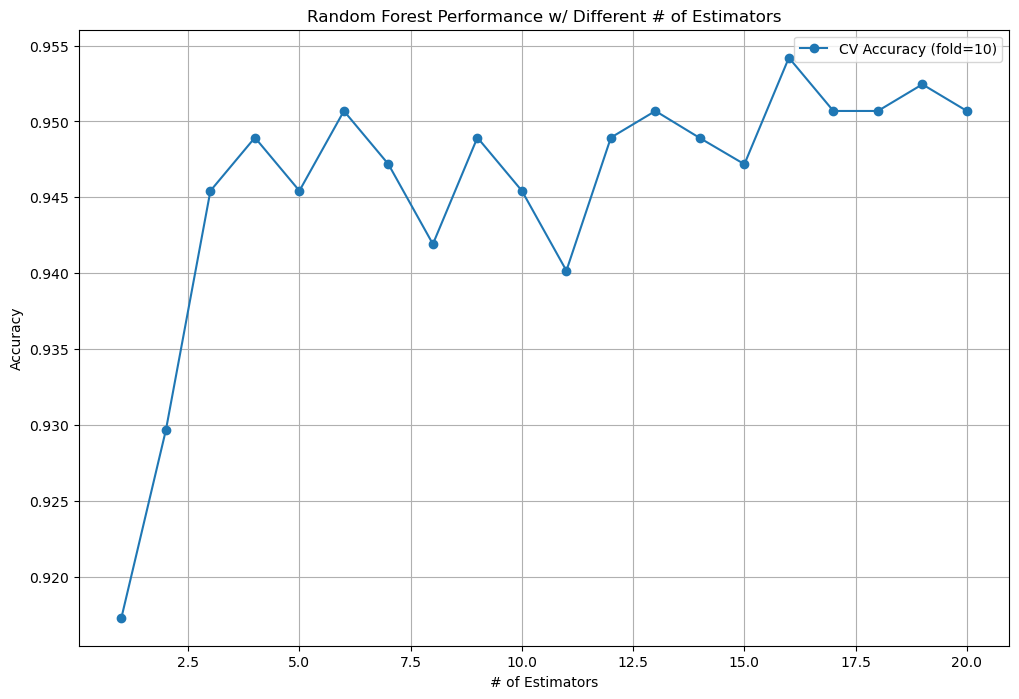

In [96]:
# Plot the results
plt.figure(figsize=FIGSIZE)
plt.plot(range(1, 21), cv_acc_rf_list, marker='o', label='CV Accuracy (fold=10)')
plt.xlabel('# of Estimators')
plt.ylabel('Accuracy')
plt.title('Random Forest Performance w/ Different # of Estimators')
plt.legend()
plt.grid(True)
plt.show()

In [97]:
# Find the maximum cross-validated accuracy for Random Forest
max_cv_acc_rf = max(cv_acc_rf_list)

# Find all n_estimators settings that resulted in the maximum cross-validated accuracy
best_n_estimators = [n for n, accuracy in enumerate(cv_acc_rf_list, start=1) if accuracy == max_cv_acc_rf]

best_n_estimators, max_cv_acc_rf

([16], 0.9541979949874687)

### (b) 
Do you see an improvement using random forests versus using a single tree? (Note: use
the `n_estimators`=1 result as the result for a single tree.)

**Student answer here:** Yes, there was an improvement in performance as increasing the number of estimators definitely was an increasing trend in performance from a single tree

### (c) 
What setting of `n_estimators` gave the best accuracy w.r.t. the cross-validated accuracy?

**Student answer here:** 16 with result of 0.954

### (d) 
For the second plot, again use a `ensemble.RandomForestClassifier`, but this time
you will fix the `n_estimators` parameter and again attempt to find the optimal setting
of a `max_depth`. Use your answer to 3c as the setting for `n_estimators` and follow the
procedure from 2a to find the best setting for max depth. This time, only plot the results
from cross-validation and not the full set, but the plot should be the same structure
as in 2a otherwise (use `max_depth` = 1,2,. . . ,10). Again, use 10 as your random seed.

In [98]:
# Initialize list to store cross-validated accuracy results
cv_acc_rf_depth_list = []

# Vary the max_depth parameter from 1 to 10
for max_depth in range(1, 11):
    # Initialize the RandomForestClassifier with the specified random seed and n_estimators
    clf = RandomForestClassifier(n_estimators=16, max_depth=max_depth, random_state=RANDOM_STATE)
    
    # Perform 10-fold cross-validation
    cv_acc_rf_depth = np.mean(cross_val_score(clf, X, y, cv=cv))
    cv_acc_rf_depth_list.append(cv_acc_rf_depth)

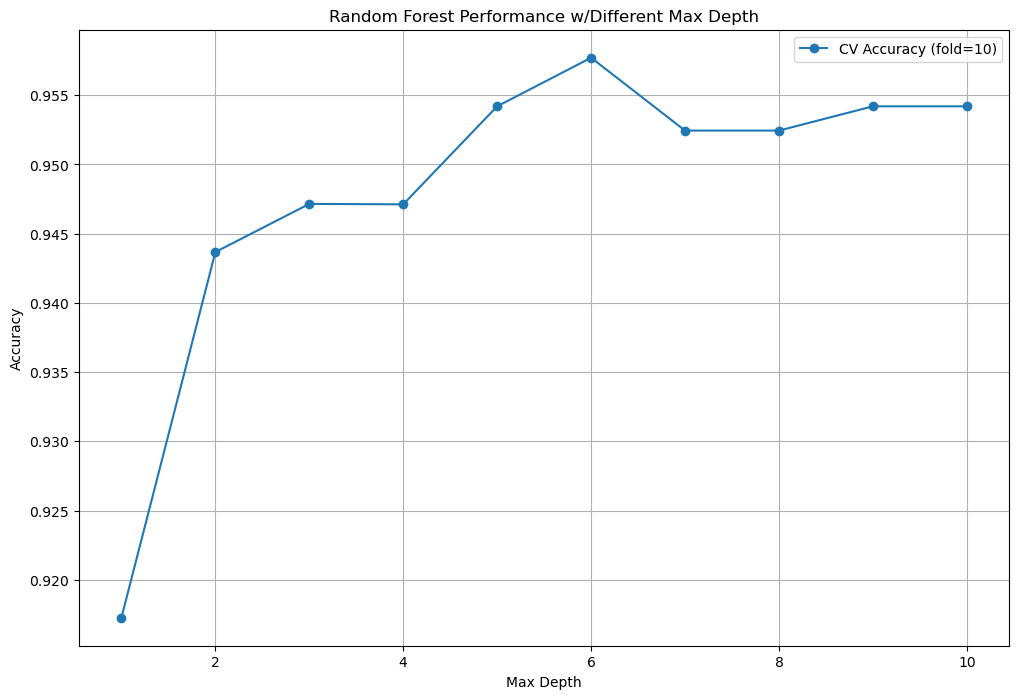

In [99]:
# Plot the results
plt.figure(figsize=FIGSIZE)
plt.plot(range(1, 11), cv_acc_rf_depth_list, marker='o', label='CV Accuracy (fold=10)')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Random Forest Performance w/Different Max Depth')
plt.legend()
plt.grid(True)
plt.show()

In [100]:
# Find the maximum cross-validated accuracy for Random Forest with varying max_depth
max_cv_acc_rf_depth = max(cv_acc_rf_depth_list)

# Find all max_depth settings that resulted in the maximum cross-validated accuracy
best_max_depths_rf = [depth for depth, accuracy in enumerate(cv_acc_rf_depth_list, start=1) if accuracy == max_cv_acc_rf_depth]

best_max_depths_rf, max_cv_acc_rf_depth

([6], 0.9577067669172932)

### (e) 
In the plot in 3d, is the optimal setting of `max_depth` the same as in 2(b)ii? If not, what
is the new optimal setting of `max_depth`?

**Student answer here:** 6 with a result of 0.9577

## 4\. 
For this last question, we will explore the dependability of our estimates. 
### (a) 
Make a plot using the following procedure:
#### i. 
Using random state values from 0, 1, · · · , 99 calculate the 10-fold cross-validation
accuracy of different `tree.DecisionTreeClassifiers` with max depth settings from
1, 2, · · · , 10.
As before, you should use the same random state value for your classifier and cross-validation.
#### ii. 
Then record the best max depth settings for each random state. Be sure to check whether multiple settings
achieve the best accuracy.


Plot the counts for the best max depth settings as a bar chart with the max depth settings on the x-axis and the 'best parameter counts' on the y-axis (number of times that parameter was selected as the best max depth setting).

*Note*: this calculation might take some time. For debugging, try a smaller range of
random states.

In [101]:
# Initialize a dictionary to count the best max depth settings
best_max_depth_counts = {depth: 0 for depth in range(1, 11)}

# Loop through random states from 0 to 99
for random_state in range(100):
    cv_acc_rs_list = []
    
    # Loop through max depth settings from 1 to 10
    for max_depth in range(1, 11):
        # Define the KFold cross-validator with the current random state
        cv = KFold(n_splits=10, random_state=random_state, shuffle=True)
        
        # Initialize the DecisionTreeClassifier with the current random state and max depth
        clf = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)
        
        # Perform 10-fold cross-validation
        cross_val_accuracy = np.mean(cross_val_score(clf, X, y, cv=cv))
        cv_acc_rs_list.append(cross_val_accuracy)
    
    # Find the maximum cross-validated accuracy for the current random state
    max_cross_val_accuracy = max(cv_acc_rs_list)
    
    # Find all max depth settings that resulted in the maximum cross-validated accuracy
    best_depths = [depth for depth, accuracy in enumerate(cv_acc_rs_list, start=1) if accuracy == max_cross_val_accuracy]
    
    # Increment the count for each best max depth setting
    for depth in best_depths:
        best_max_depth_counts[depth] += 1

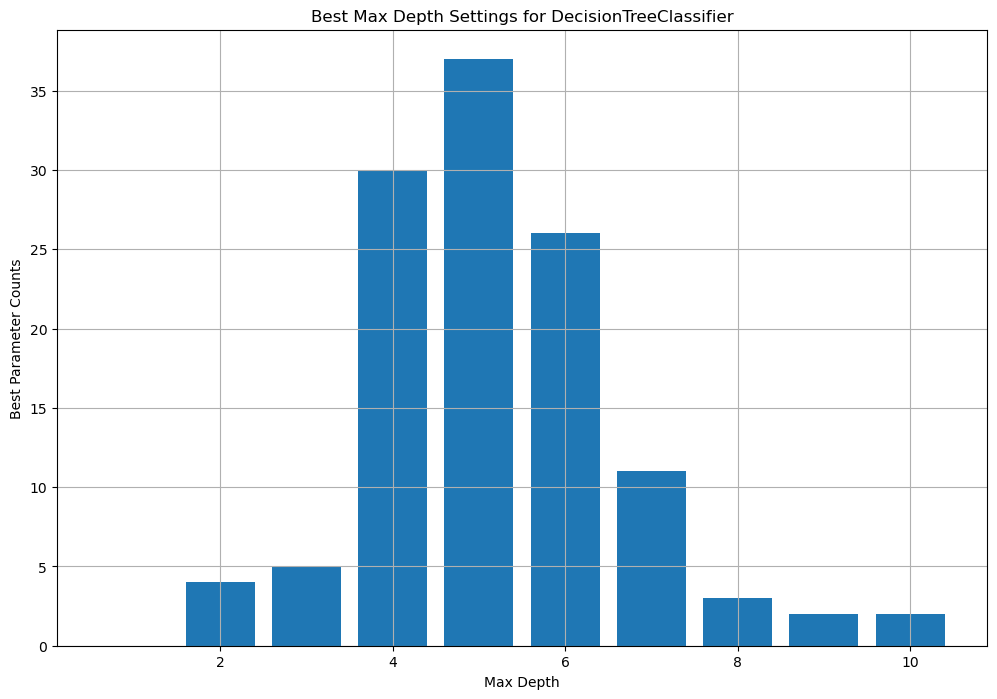

In [102]:
# Plot the results
plt.figure(figsize=FIGSIZE)
plt.bar(best_max_depth_counts.keys(), best_max_depth_counts.values())
plt.xlabel('Max Depth')
plt.ylabel('Best Parameter Counts')
plt.title('Best Max Depth Settings for DecisionTreeClassifier')
plt.grid(True)
plt.show()

### (b) 
What are the top two most frequent parameter settings?

**Student answer here:** The most frequent was 5 and then 4